<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/master/notebooks/run_cellpose_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose in colab with a GPU

(thanks to Matteo Carandini for setting this up)

UPDATED DEC 2020 for TORCH VERSION cellpose v0.6

UPDATED NOV 2021 for cellpose / omnipose v0.7

## installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

Note that cellpose uses the latest version of numpy, so please click the "Restart runtime" button once the install completes.

In [1]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

     |████████████████████████████████| 21.6 MB 12.0 MB/s 
     |████████████████████████████████| 174 kB 5.3 MB/s 
     |████████████████████████████████| 3.4 MB 42.9 MB/s 
     |████████████████████████████████| 15.7 MB 272 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Check CUDA version and GPU

In [ ]:
!nvcc --version
!nvidia-smi

import libraries and check GPU (the first time you import cellpose the models will download).

In [2]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models, core

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();


>>> GPU activated? 1
2024-02-22 21:46:57,939 [INFO] WRITING LOG OUTPUT TO /home/carsen/.cellpose/run.log
2024-02-22 21:46:57,940 [INFO] 
cellpose version: 	3.0.5.dev5+gfdd2b68 
platform:       	linux 
python version: 	3.9.18 
torch version:  	2.1.0+cu121


Download sample images

Downloading: "http://www.cellpose.org/static/data/rgb_3D.tif" to rgb_3D.tif
100%|██████████| 1.63M/1.63M [00:00<00:00, 65.2MB/s]


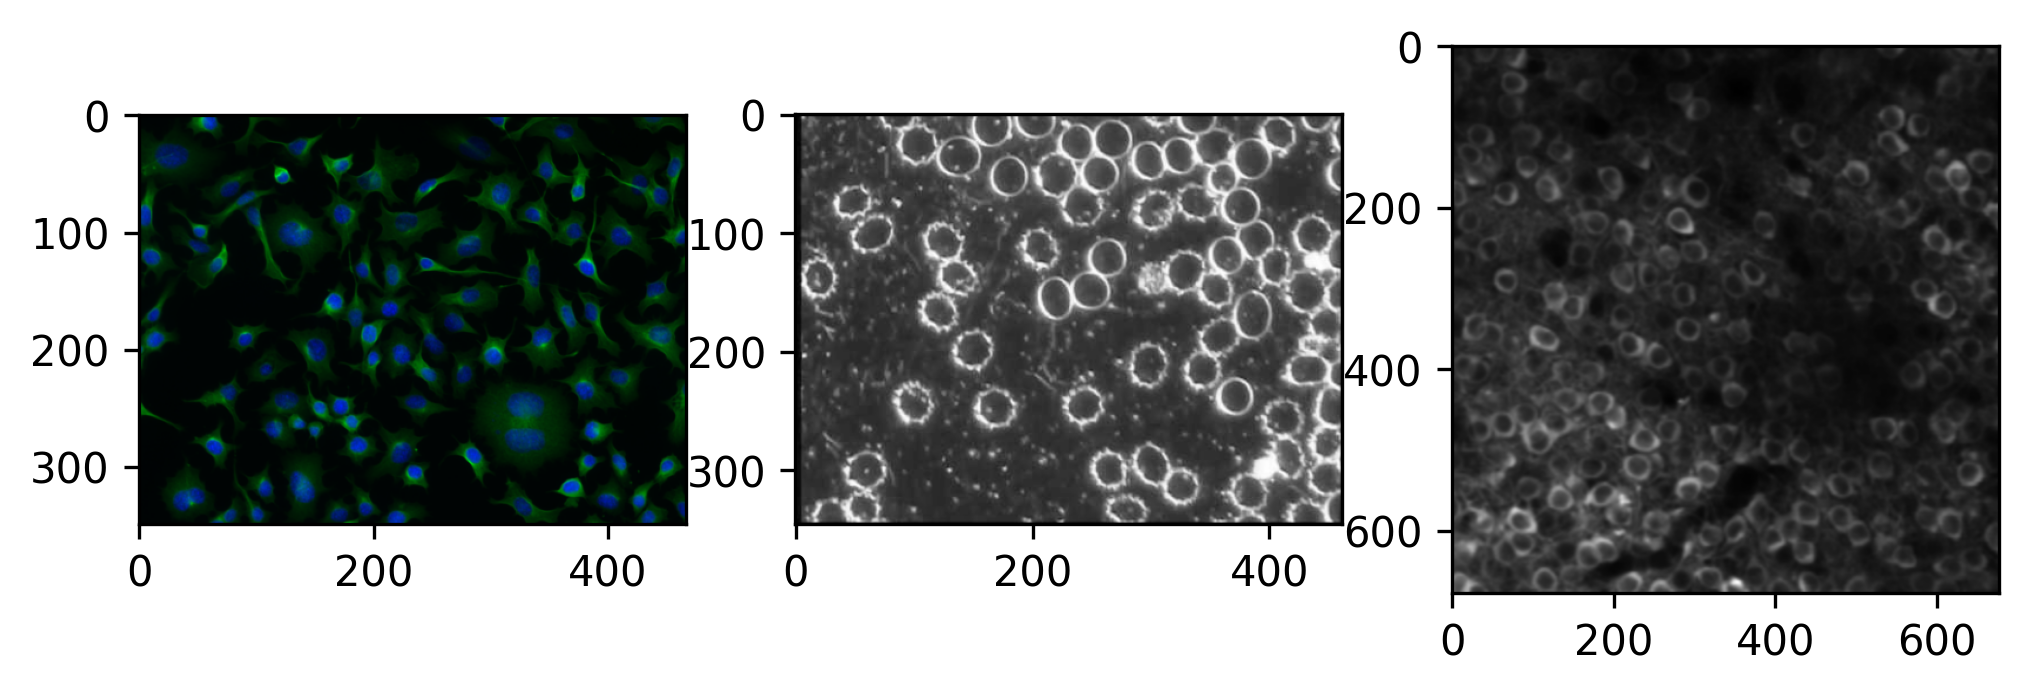

In [3]:
from cellpose import utils
# I will download images from website
urls = ['http://www.cellpose.org/static/images/img02.png',
        'http://www.cellpose.org/static/images/img03.png',
        'http://www.cellpose.org/static/images/img05.png',
        'http://www.cellpose.org/static/data/rgb_3D.tif']
files = []
for url in urls:
    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if not os.path.exists(filename):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
        utils.download_url_to_file(url, filename)
    files.append(filename)

# REPLACE FILES WITH YOUR IMAGE PATHS
# files = ['img0.tif', 'img1.tif']
    
imgs = [skimage.io.imread(f) for f in files]
nimg = len(imgs)

plt.figure(figsize=(8,4))
for k,img in enumerate(imgs[:-1]):
  plt.subplot(1,3,k+1)
  plt.imshow(img)


## run cellpose on 2D sample images

(exclude last download, it's a 3D tiff)

In [4]:
# RUN CELLPOSE

imgs_2D = imgs[:-1]

from cellpose import models

# DEFINE CELLPOSE MODEL
# model_type='cyto3' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto3')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[2,3], [0,0], [0,0]]
# channels = [1,1]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

masks, flows, styles, diams = model.eval(imgs_2D, diameter=None, flow_threshold=None, channels=channels)

2024-02-22 21:47:06,385 [INFO] ** TORCH CUDA version installed and working. **
2024-02-22 21:47:06,386 [INFO] >>>> using GPU
2024-02-22 21:47:06,388 [INFO] >> cyto3 << model set to be used
2024-02-22 21:47:06,557 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-02-22 21:47:06,559 [INFO] channels set to [[2, 3], [0, 0], [0, 0]]
2024-02-22 21:47:06,560 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2024-02-22 21:47:09,651 [INFO] 100%|##########| 3/3 [00:03<00:00,  1.03s/it]
2024-02-22 21:47:09,652 [INFO] estimated cell diameter(s) in 3.09 sec
2024-02-22 21:47:09,653 [INFO] >>> diameter(s) = 
2024-02-22 21:47:09,654 [INFO] [29.67, 33.79, 31.10, ]
2024-02-22 21:47:09,655 [INFO] ~~~ FINDING MASKS ~~~
2024-02-22 21:47:10,069 [INFO] 100%|##########| 3/3 [00:00<00:00,  7.28it/s]
2024-02-22 21:47:10,070 [INFO] >>>> TOTAL TIME 3.51 sec


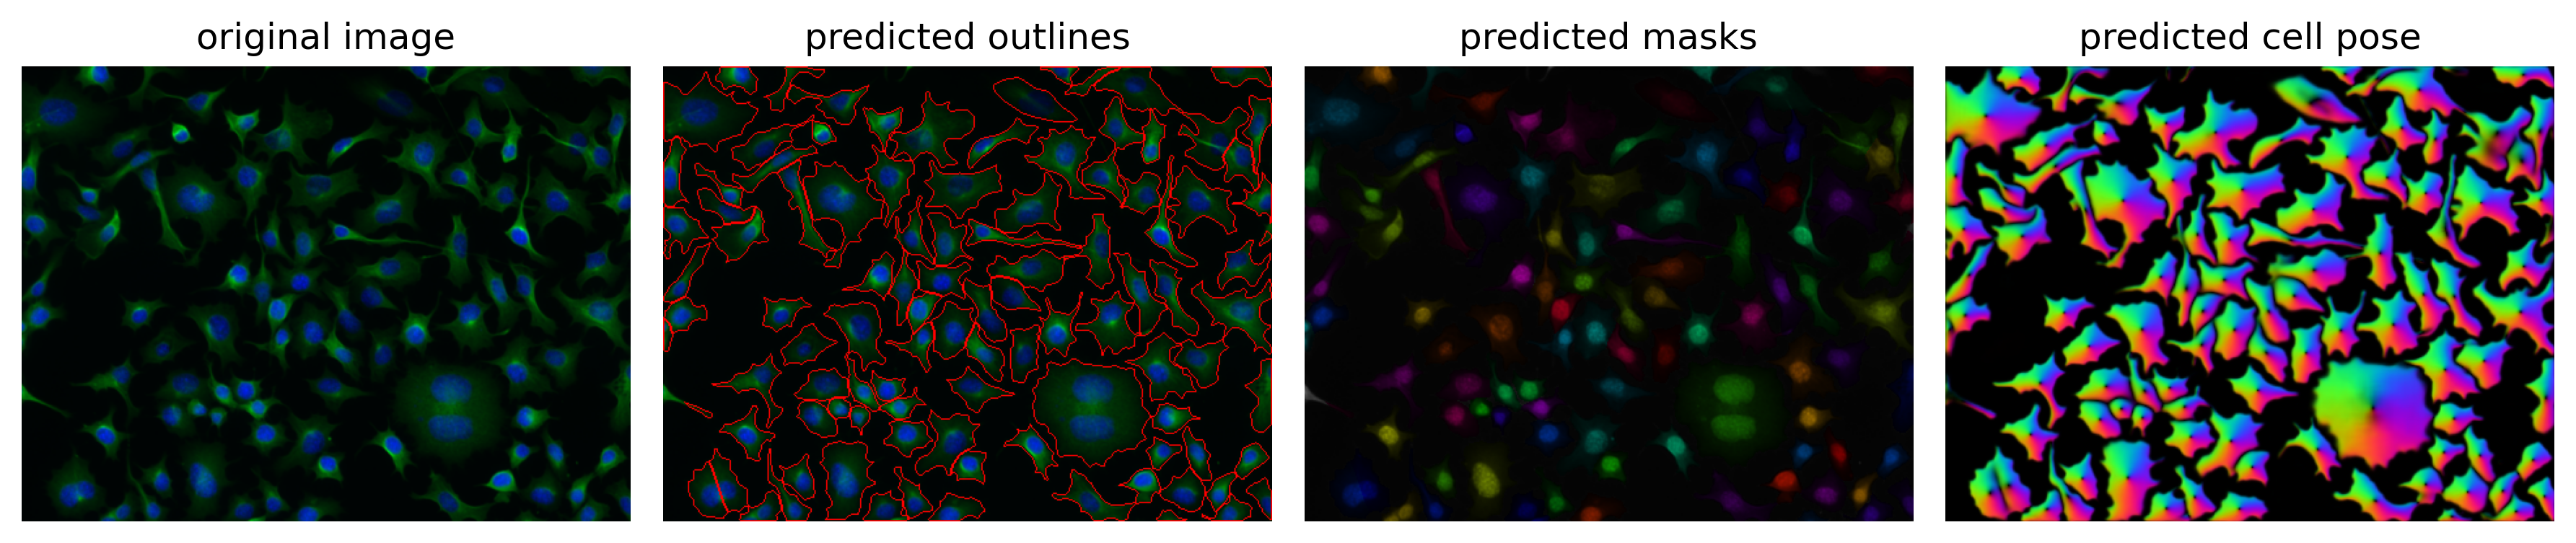

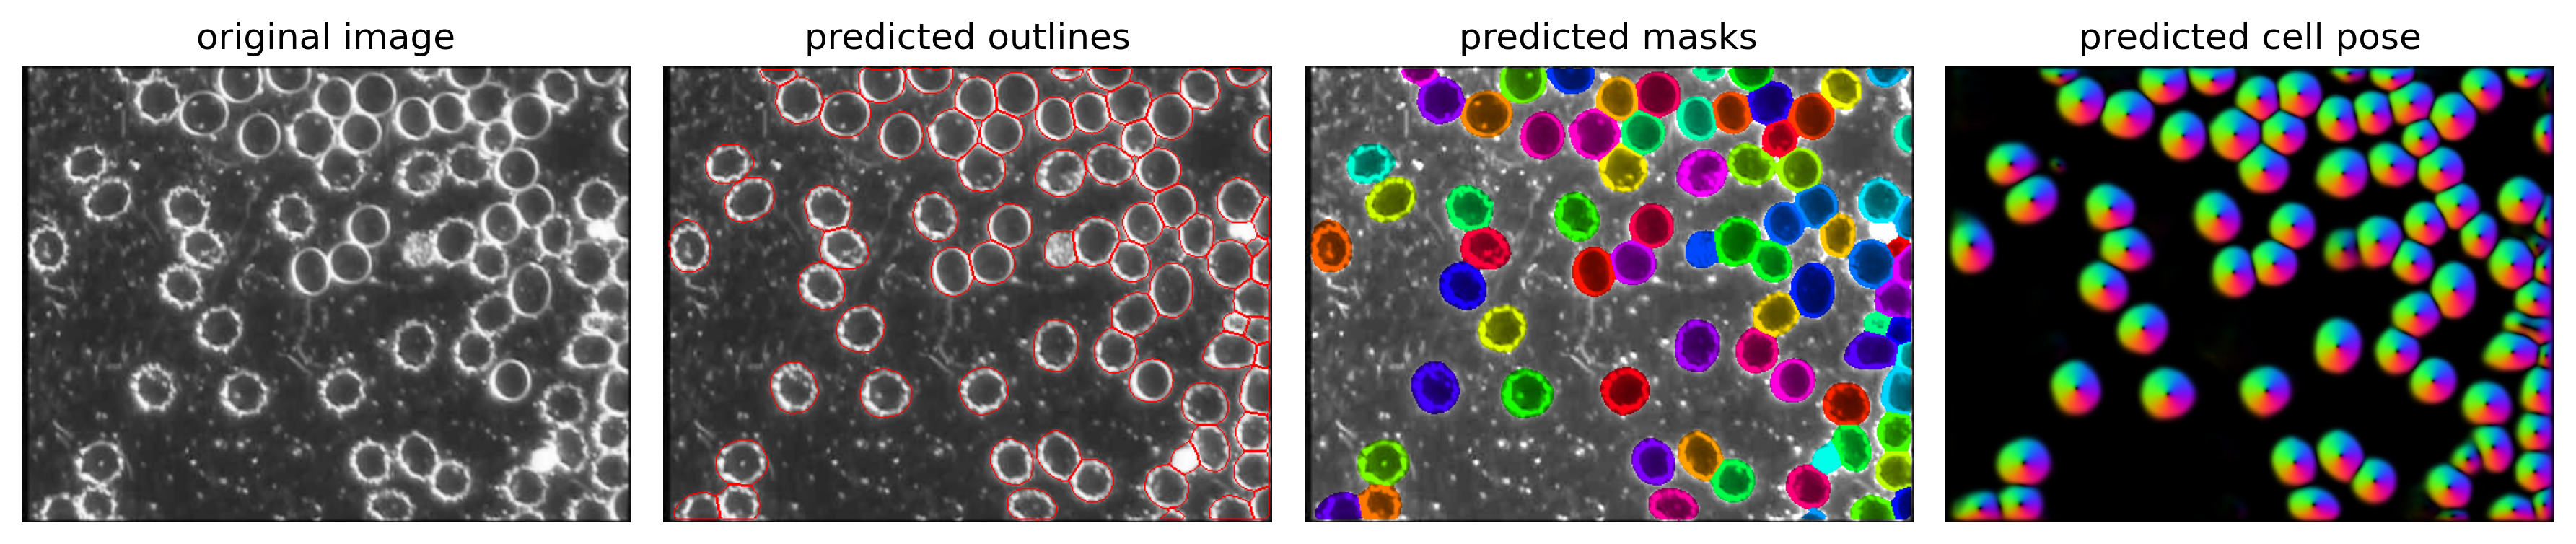

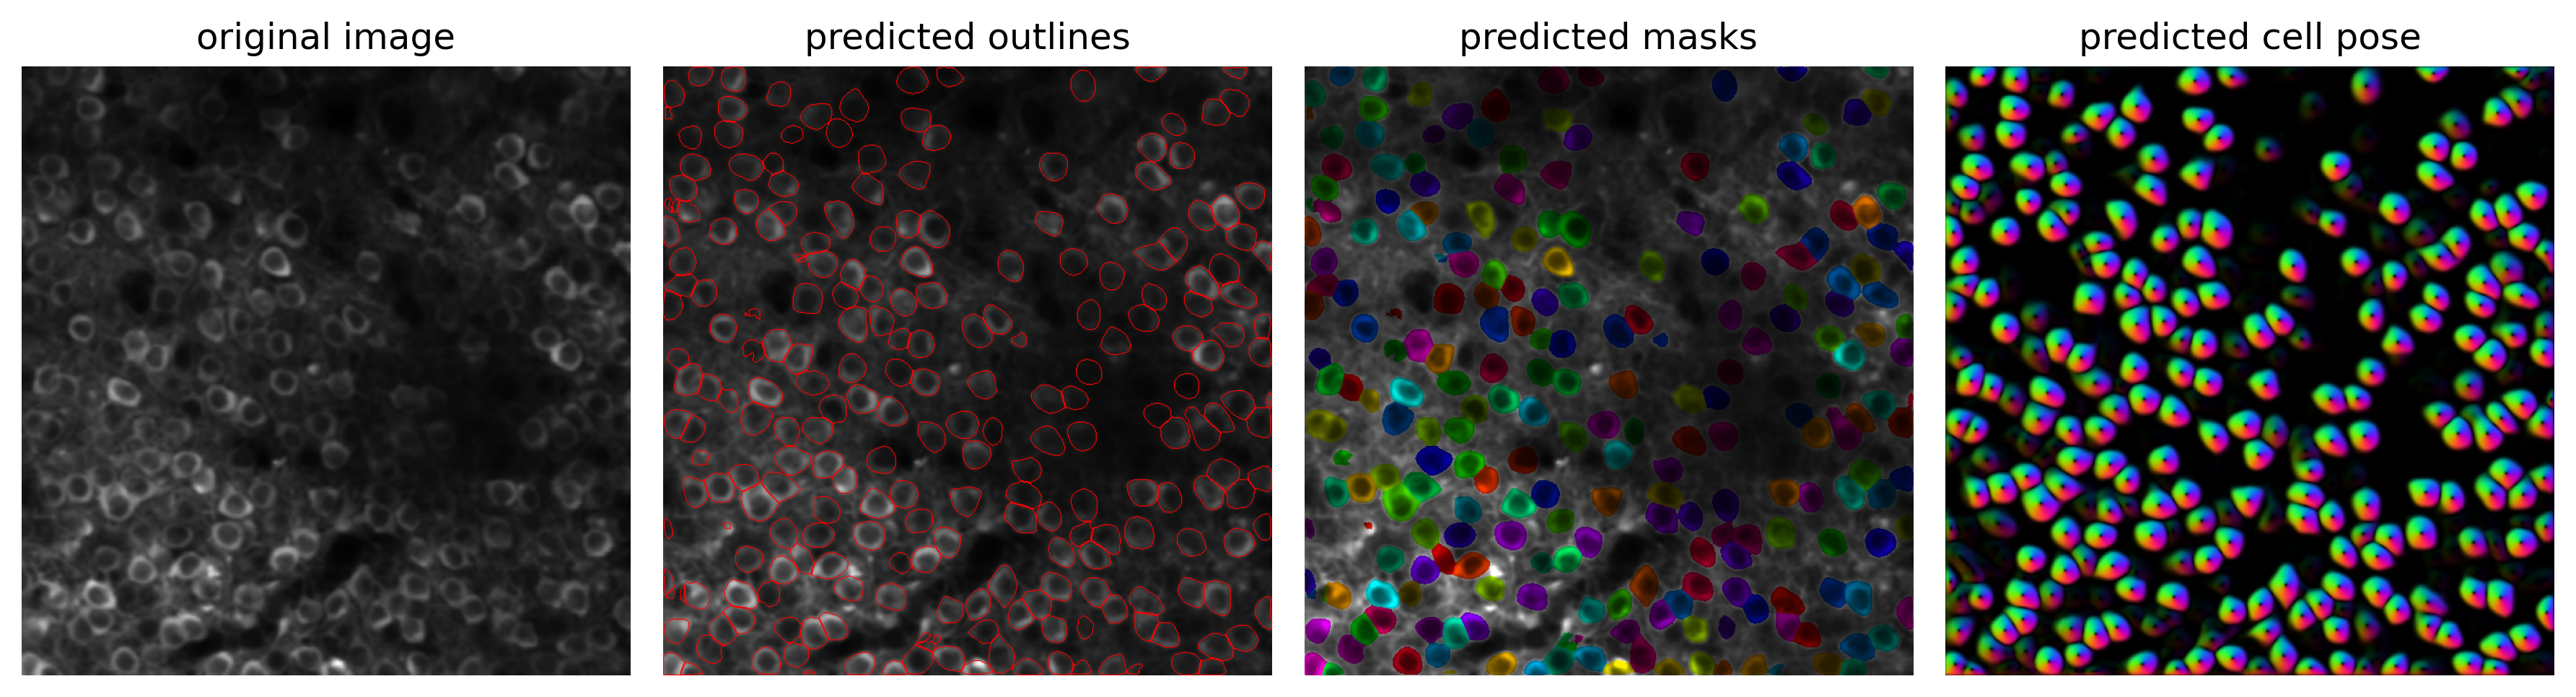

In [5]:
# DISPLAY RESULTS
from cellpose import plot

nimg = len(imgs_2D)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
    plt.tight_layout()
    plt.show()

## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

In [6]:
from cellpose import io

io.masks_flows_to_seg(imgs_2D, masks, flows, files, channels=channels, diams=diams)

## run cellpose 3D

There are two ways to run cellpose in 3D, this cell shows both, choose which one works best for you.

First way: computes flows from 2D slices and combines into 3D flows to create masks



In [7]:
# test 3D stack

img_3D = imgs[-1]

# * with 3D you have to set the diameter manually (no auto detect) *

### TWO WAYS TO RUN CELLPOSE IN 3D

# 1. computes flows from 2D slices and combines into 3D flows to create masks
print('running cellpose 2D slice flows => masks')
masks, flows, styles, _ = model.eval(img_3D, channels=[2,1], diameter=25, do_3D=True)


running cellpose 2D slice flows => masks
2024-02-22 21:47:30,700 [INFO] channels set to [2, 1]
2024-02-22 21:47:30,703 [INFO] ~~~ FINDING MASKS ~~~
2024-02-22 21:47:30,705 [INFO] multi-stack tiff read in as having 75 planes 2 channels
2024-02-22 21:47:30,739 [INFO] running YX: 75 planes of size (75, 75)
2024-02-22 21:47:30,926 [INFO] 100%|##########| 3/3 [00:00<00:00, 16.85it/s]
2024-02-22 21:47:30,949 [INFO] running ZY: 75 planes of size (75, 75)
2024-02-22 21:47:31,046 [INFO] 100%|##########| 3/3 [00:00<00:00, 34.26it/s]
2024-02-22 21:47:31,069 [INFO] running ZX: 75 planes of size (75, 75)
2024-02-22 21:47:31,161 [INFO] 100%|##########| 3/3 [00:00<00:00, 36.40it/s]
2024-02-22 21:47:31,176 [INFO] network run in 0.47s
2024-02-22 21:47:31,626 [INFO] masks created in 0.45s
2024-02-22 21:47:31,652 [INFO] >>>> TOTAL TIME 0.95 sec


Second way: computes masks in 2D slices and stitches masks in 3D based on mask overlap

Note stitching (with stitch_threshold > 0) can also be used to track cells over time.

In [8]:
# 2. computes masks in 2D slices and stitches masks in 3D based on mask overlap
print('running cellpose 2D + stitching masks')
masks_stitched, flows_stitched, styles_stitched, _ = model.eval(img_3D, channels=[2,1], diameter=25, do_3D=False, stitch_threshold=0.5)

running cellpose 2D + stitching masks
2024-02-22 21:47:35,226 [INFO] channels set to [2, 1]
2024-02-22 21:47:35,229 [INFO] ~~~ FINDING MASKS ~~~
2024-02-22 21:47:35,232 [INFO] multi-stack tiff read in as having 75 planes 2 channels
2024-02-22 21:47:36,009 [INFO] 100%|##########| 75/75 [00:00<00:00, 99.87it/s]
2024-02-22 21:47:36,013 [INFO] network run in 0.78s
2024-02-22 21:47:38,801 [INFO] 100%|##########| 75/75 [00:02<00:00, 26.95it/s]
2024-02-22 21:47:38,805 [INFO] stitching 75 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 74/74 [00:00<00:00, 94.92it/s]

2024-02-22 21:47:39,607 [INFO] masks created in 3.59s
2024-02-22 21:47:39,626 [INFO] >>>> TOTAL TIME 4.40 sec


Results from 3D flows => masks computation

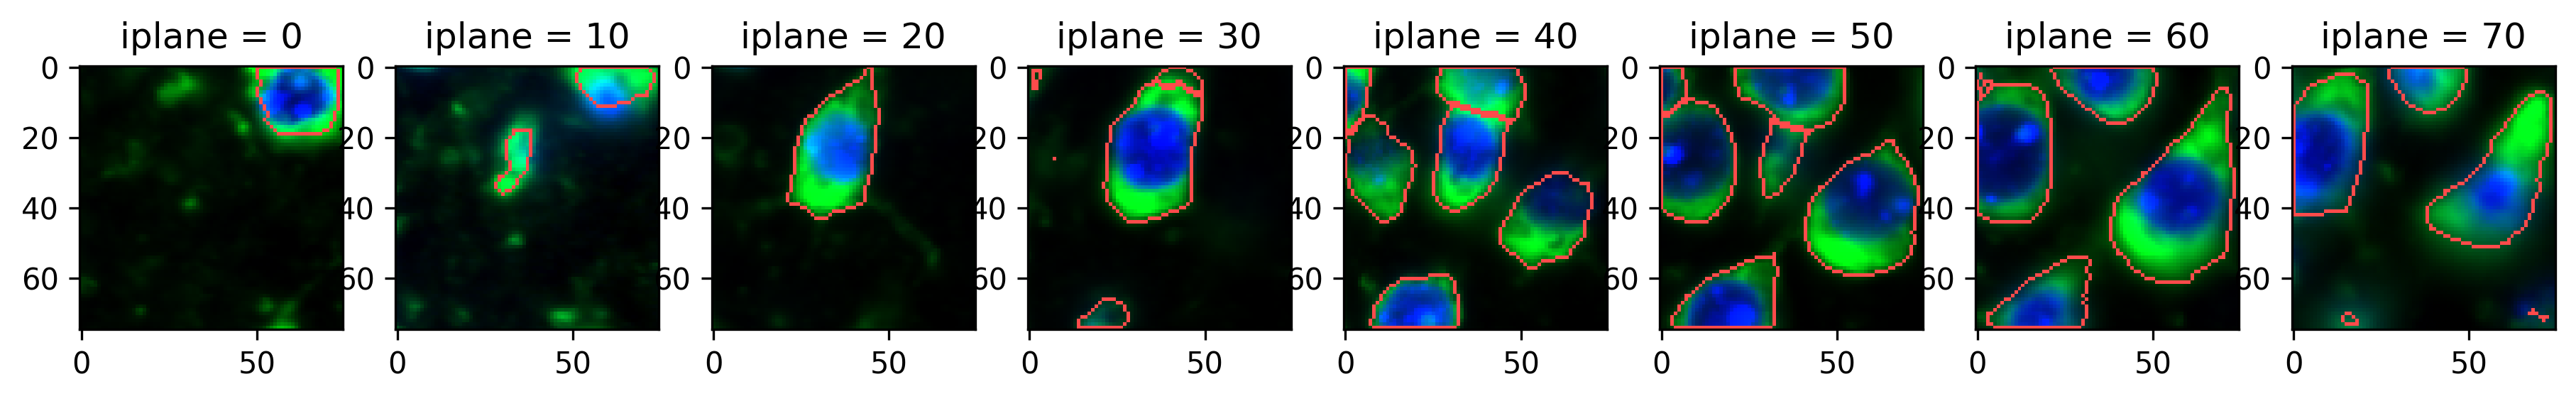

In [9]:
# DISPLAY RESULTS 3D flows => masks
plt.figure(figsize=(15,3))
for i,iplane in enumerate(np.arange(0,75,10,int)):
  img0 = plot.image_to_rgb(img_3D[iplane, [1,0]].copy(), channels=[2,3])
  plt.subplot(1,8,i+1)
  outlines = utils.masks_to_outlines(masks[iplane])
  outX, outY = np.nonzero(outlines)
  imgout= img0.copy()
  imgout[outX, outY] = np.array([255,75,75])
  plt.imshow(imgout)
  plt.title('iplane = %d'%iplane)

Results from stitching

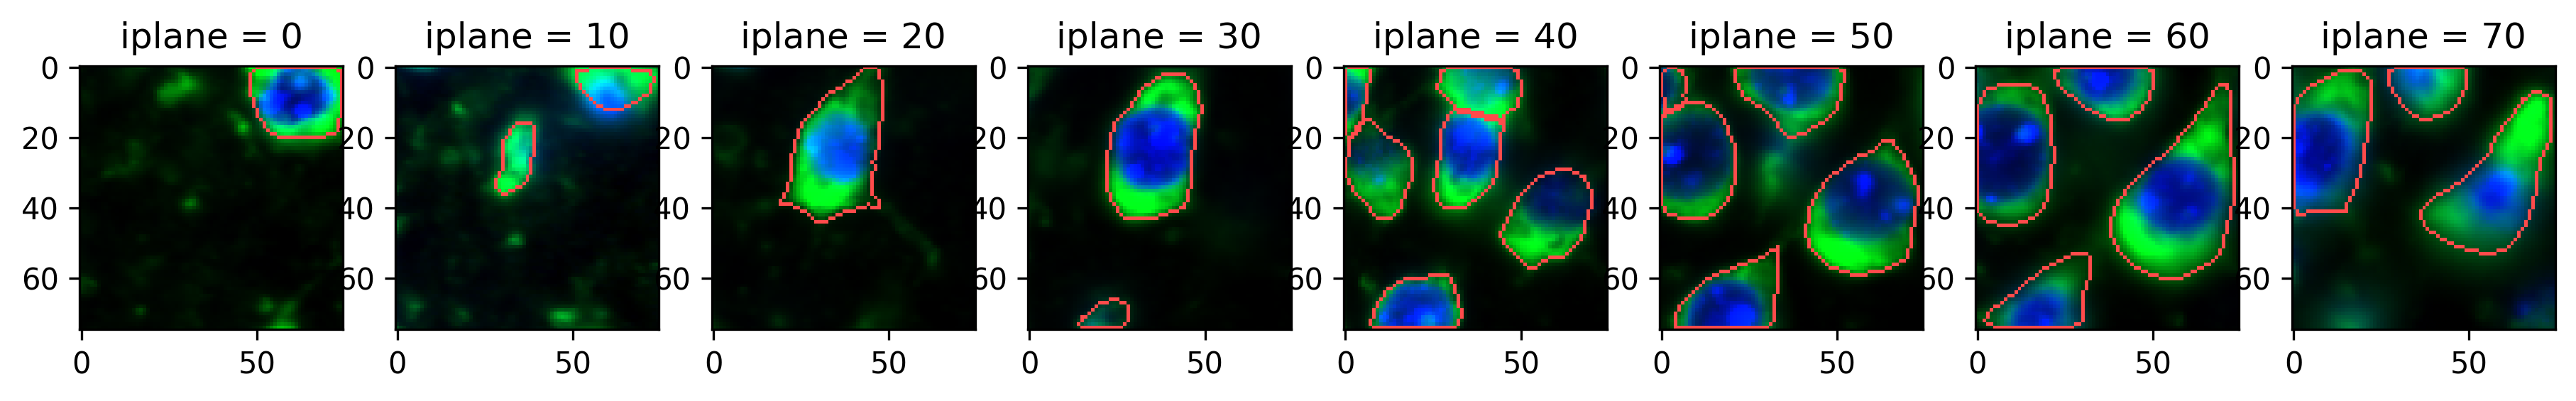

In [10]:
# DISPLAY RESULTS stitching
plt.figure(figsize=(15,3))
for i,iplane in enumerate(np.arange(0,75,10,int)):
  img0 = plot.image_to_rgb(img_3D[iplane, [1,0]].copy(), channels=[2,3])
  plt.subplot(1,8,i+1)
  outlines = utils.masks_to_outlines(masks_stitched[iplane])
  outX, outY = np.nonzero(outlines)
  imgout= img0.copy()
  imgout[outX, outY] = np.array([255,75,75])
  plt.imshow(imgout)
  plt.title('iplane = %d'%iplane)

## connect to your google drive

so that you can run your own files (alternatively, upload them directly to the Files tab)

In [ ]:
## RUN THIS CELL TO ACCESS GOOGLE DRIVE

# mount your google drive here if you want to access your own files
from google.colab import drive
drive.mount('/content/drive')

# files will be in
# file_root = '/content/drive/My Drive/'